# Sarcasm detection using text data

In [4]:
import pandas as pd 
import json
import numpy as np

# Exploratory Data Analysis

In [5]:
df = pd.read_json('./sarcasm_data.json', orient='index')
print(df)
df.reset_index(drop=True, inplace=True)

                                              utterance   speaker   
160   It's just a privilege to watch your mind at work.   SHELDON  \
170   I don't think I'll be able to stop thinking ab...     PENNY   
180   Since it's not bee season, you can have my epi...   SHELDON   
190   Lois Lane is falling, accelerating at an initi...   SHELDON   
1105  I'm just inferring this is a couch because the...   SHELDON   
...                                                 ...       ...   
2169  Hes not right for the part, and if I suggest h...  CHANDLER   
2235  Oh yeah he has a caretaker his older brother, ...  CHANDLER   
234   Is it me or the greetings gone downhill around...  CHANDLER   
2608  You are right, by saying nice, I am virtually ...  CHANDLER   
2524            Yes and we are "very" excited about it.  CHANDLER   

                                                context   
160   [I never would have identified the fingerprint...  \
170   [This is one of my favorite places to kick bac.

In [6]:
# print descriptive statistics of the data, including mean, standard deviation, median, etc.
basic_info = df.describe()
print(basic_info)

       utterance   speaker                                            context   
count        690       690                                                690  \
unique       681        21                                                690   
top        Okay?  CHANDLER  [I never would have identified the fingerprint...   
freq           3       158                                                  1   

       context_speakers     show sarcasm  
count               690      690     690  
unique              418        4       2  
top              [JOEY]  FRIENDS    True  
freq                 25      356     345  


/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_34824/3442264699.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['sarcasm'], palette='bright')
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


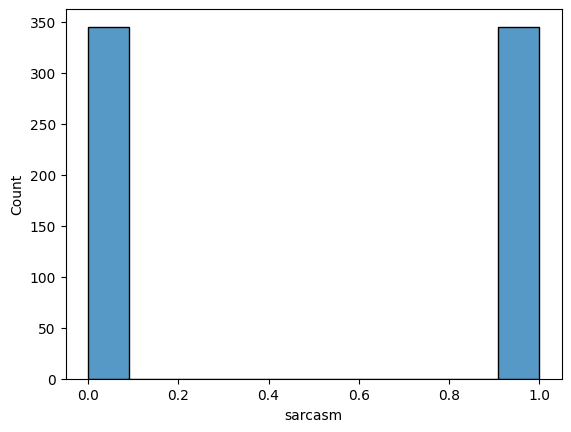

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# check for missing values; verdict = none
df.isna().sum()

# distribution of negative and positive sentiments
sns.histplot(data=df['sarcasm'], palette='bright')
plt.show()
# much more negative than positive sentiments

# Text Preprocessing

In [8]:
import nltk
import contractions
import re

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinelin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinelin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/christinelin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
def tokenize(column):

    for word in column.split():
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return expanded_tokens

In [10]:
def join_tokens(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return " ".join(expanded_tokens)

In [11]:
df['tokenized'] = df.apply(lambda x: tokenize(x['utterance']), axis=1)
df['joined tokens'] = df.apply(lambda x: join_tokens(x['utterance']), axis=1)

df[['sarcasm','tokenized','joined tokens']].tail()

,sarcasm,tokenized,joined tokens
685,True,"[he, not, right, for, the, part, and, if, i, s...",he not right for the part and if i suggest him...
686,False,"[oh, yeah, he, ha, a, caretaker, his, older, b...",oh yeah he ha a caretaker his older brother er...
687,True,"[is, it, me, or, the, greeting, gone, downhill...",is it me or the greeting gone downhill around ...
688,True,"[you, are, right, by, saying, nice, i, am, vir...",you are right by saying nice i am virtually li...
689,True,"[yes, and, we, are, very, excited, about, it]",yes and we are very excited about it


# Linguistic Feature Extraction

In [12]:
# Bag of words model
from sklearn.feature_extraction.text import CountVectorizer

corpus = []
for data in df['joined tokens']:
    corpus.append(data)

# Create a Count Vectorizer Object
vectorizer  = CountVectorizer(max_features=1000, ngram_range=(1,2))
bow_vector = vectorizer.fit_transform(corpus)

In [13]:
# TF*IDF model
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []
for data in df['joined tokens']:
    corpus.append(data)

# Create a Tfid Vectorizer Object
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
tfidf_vector = vectorizer.fit_transform(corpus)

In [14]:
# trying something else for w2v
import gensim
from gensim.models import Word2Vec

sentences = [sentence for sentence in df['joined tokens']]
w2v_model = Word2Vec(sentences, vector_size=1000, window=5, min_count=5, workers=4)

In [15]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(1000)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


# Build Sarcasm Detection Model

In [16]:
# Import classifiers and metrics from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

lc = LogisticRegression()
neigh = KNeighborsClassifier(n_neighbors=3)
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

In [17]:
# # SMOTE for Imbalanced Classification
from imblearn.over_sampling import SMOTE

def train_and_predict_models():
    y = df['sarcasm'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    over_sampled_X_train, X_test, over_sampled_y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    oversample = SMOTE()
    over_sampled_X_train, over_sampled_y_train = oversample.fit_resample(X_train, y_train)

    lc.fit(over_sampled_X_train, over_sampled_y_train)
    neigh.fit(over_sampled_X_train, over_sampled_y_train)
    svc.fit(over_sampled_X_train, over_sampled_y_train)
    nbc.fit(over_sampled_X_train, over_sampled_y_train)
    rfc.fit(over_sampled_X_train, over_sampled_y_train)

    y_lc_predicted = lc.predict(X_test)
    y_lc_pred_proba = lc.predict_proba(X_test)

    y_knn_predicted = neigh.predict(X_test)
    y_knn_pred_proba = neigh.predict_proba(X_test)

    y_svc_predicted = svc.predict(X_test)
    y_svc_pred_proba = svc.predict_proba(X_test)

    y_nbc_predicted = nbc.predict(X_test)
    y_nbc_pred_proba = nbc.predict_proba(X_test)

    y_rfc_predicted = rfc.predict(X_test)
    y_rfc_pred_proba = rfc.predict_proba(X_test)

    print('Logistic Regression:\n', classification_report(y_test, y_lc_predicted))
    print('K Nearest Neighbor:\n', classification_report(y_test, y_knn_predicted))
    print('Support Vector Machine:\n', classification_report(y_test, y_svc_predicted))
    print('Naive Bayes Classification:\n', classification_report(y_test, y_nbc_predicted))
    print('Random Forest classification:\n', classification_report(y_test, y_rfc_predicted))

    models = ['Logistic Regression', 'K Nearest Neighbor', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
    predictions = [y_lc_predicted, y_knn_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
    pred_probabilities = [y_lc_pred_proba, y_knn_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

    plot = 1

    for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
        disp.plot(
            include_values=True,
            cmap='gray',
            colorbar=False
        )
        disp.ax_.set_title(f"{model} Confusion Matrix")

    plt.figure(figsize=(30, 15))
    plt.suptitle("ROC Curves")
    plot_index = 1

    for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
        auc_score = auc(fpr, tpr)
        plt.subplot(3, 2, plot_index)
        plt.plot(fpr, tpr, 'r', label='ROC curve')
        # pyplot.figure(figsize=(5, 5))
        plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
        plt.xlabel('FPR', fontsize=12)
        plt.ylabel('TPR', fontsize=12)
        plt.legend()
        plot_index += 1
    plt.show()

Bag of Words: 

Logistic Regression:
               precision    recall  f1-score   support

       False       0.50      0.60      0.55        53
        True       0.72      0.62      0.67        85

    accuracy                           0.62       138
   macro avg       0.61      0.61      0.61       138
weighted avg       0.63      0.62      0.62       138

K Nearest Neighbor:
               precision    recall  f1-score   support

       False       0.49      0.57      0.53        53
        True       0.70      0.64      0.67        85

    accuracy                           0.61       138
   macro avg       0.60      0.60      0.60       138
weighted avg       0.62      0.61      0.61       138

Support Vector Machine:
               precision    recall  f1-score   support

       False       0.50      0.62      0.55        53
        True       0.72      0.61      0.66        85

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.61 

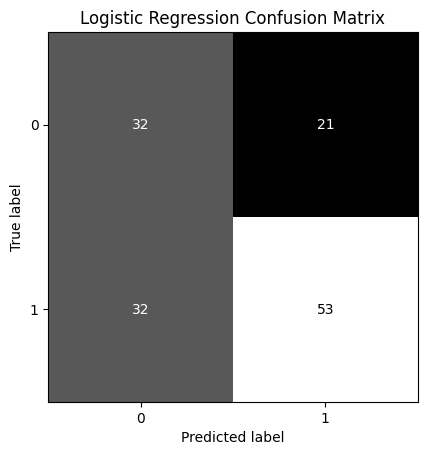

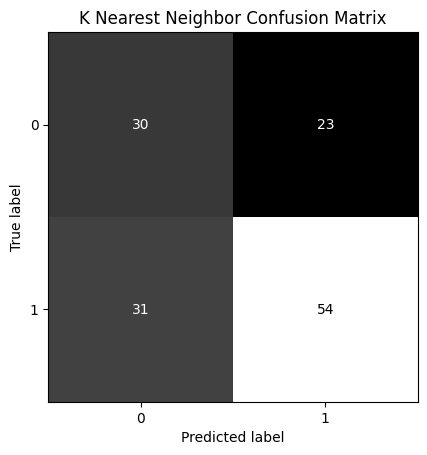

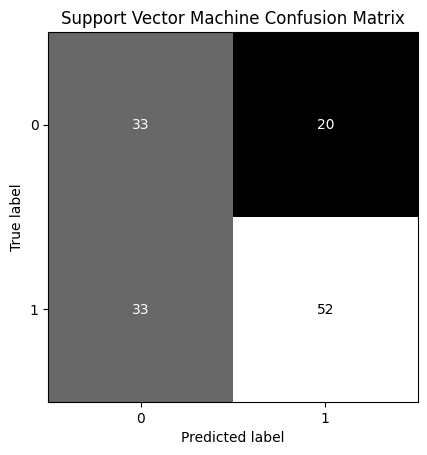

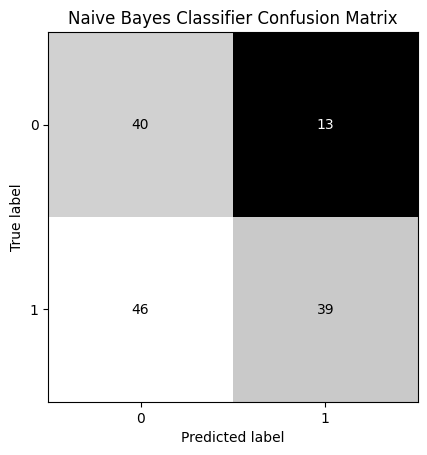

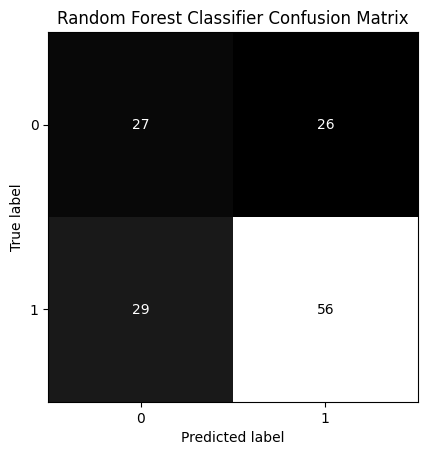

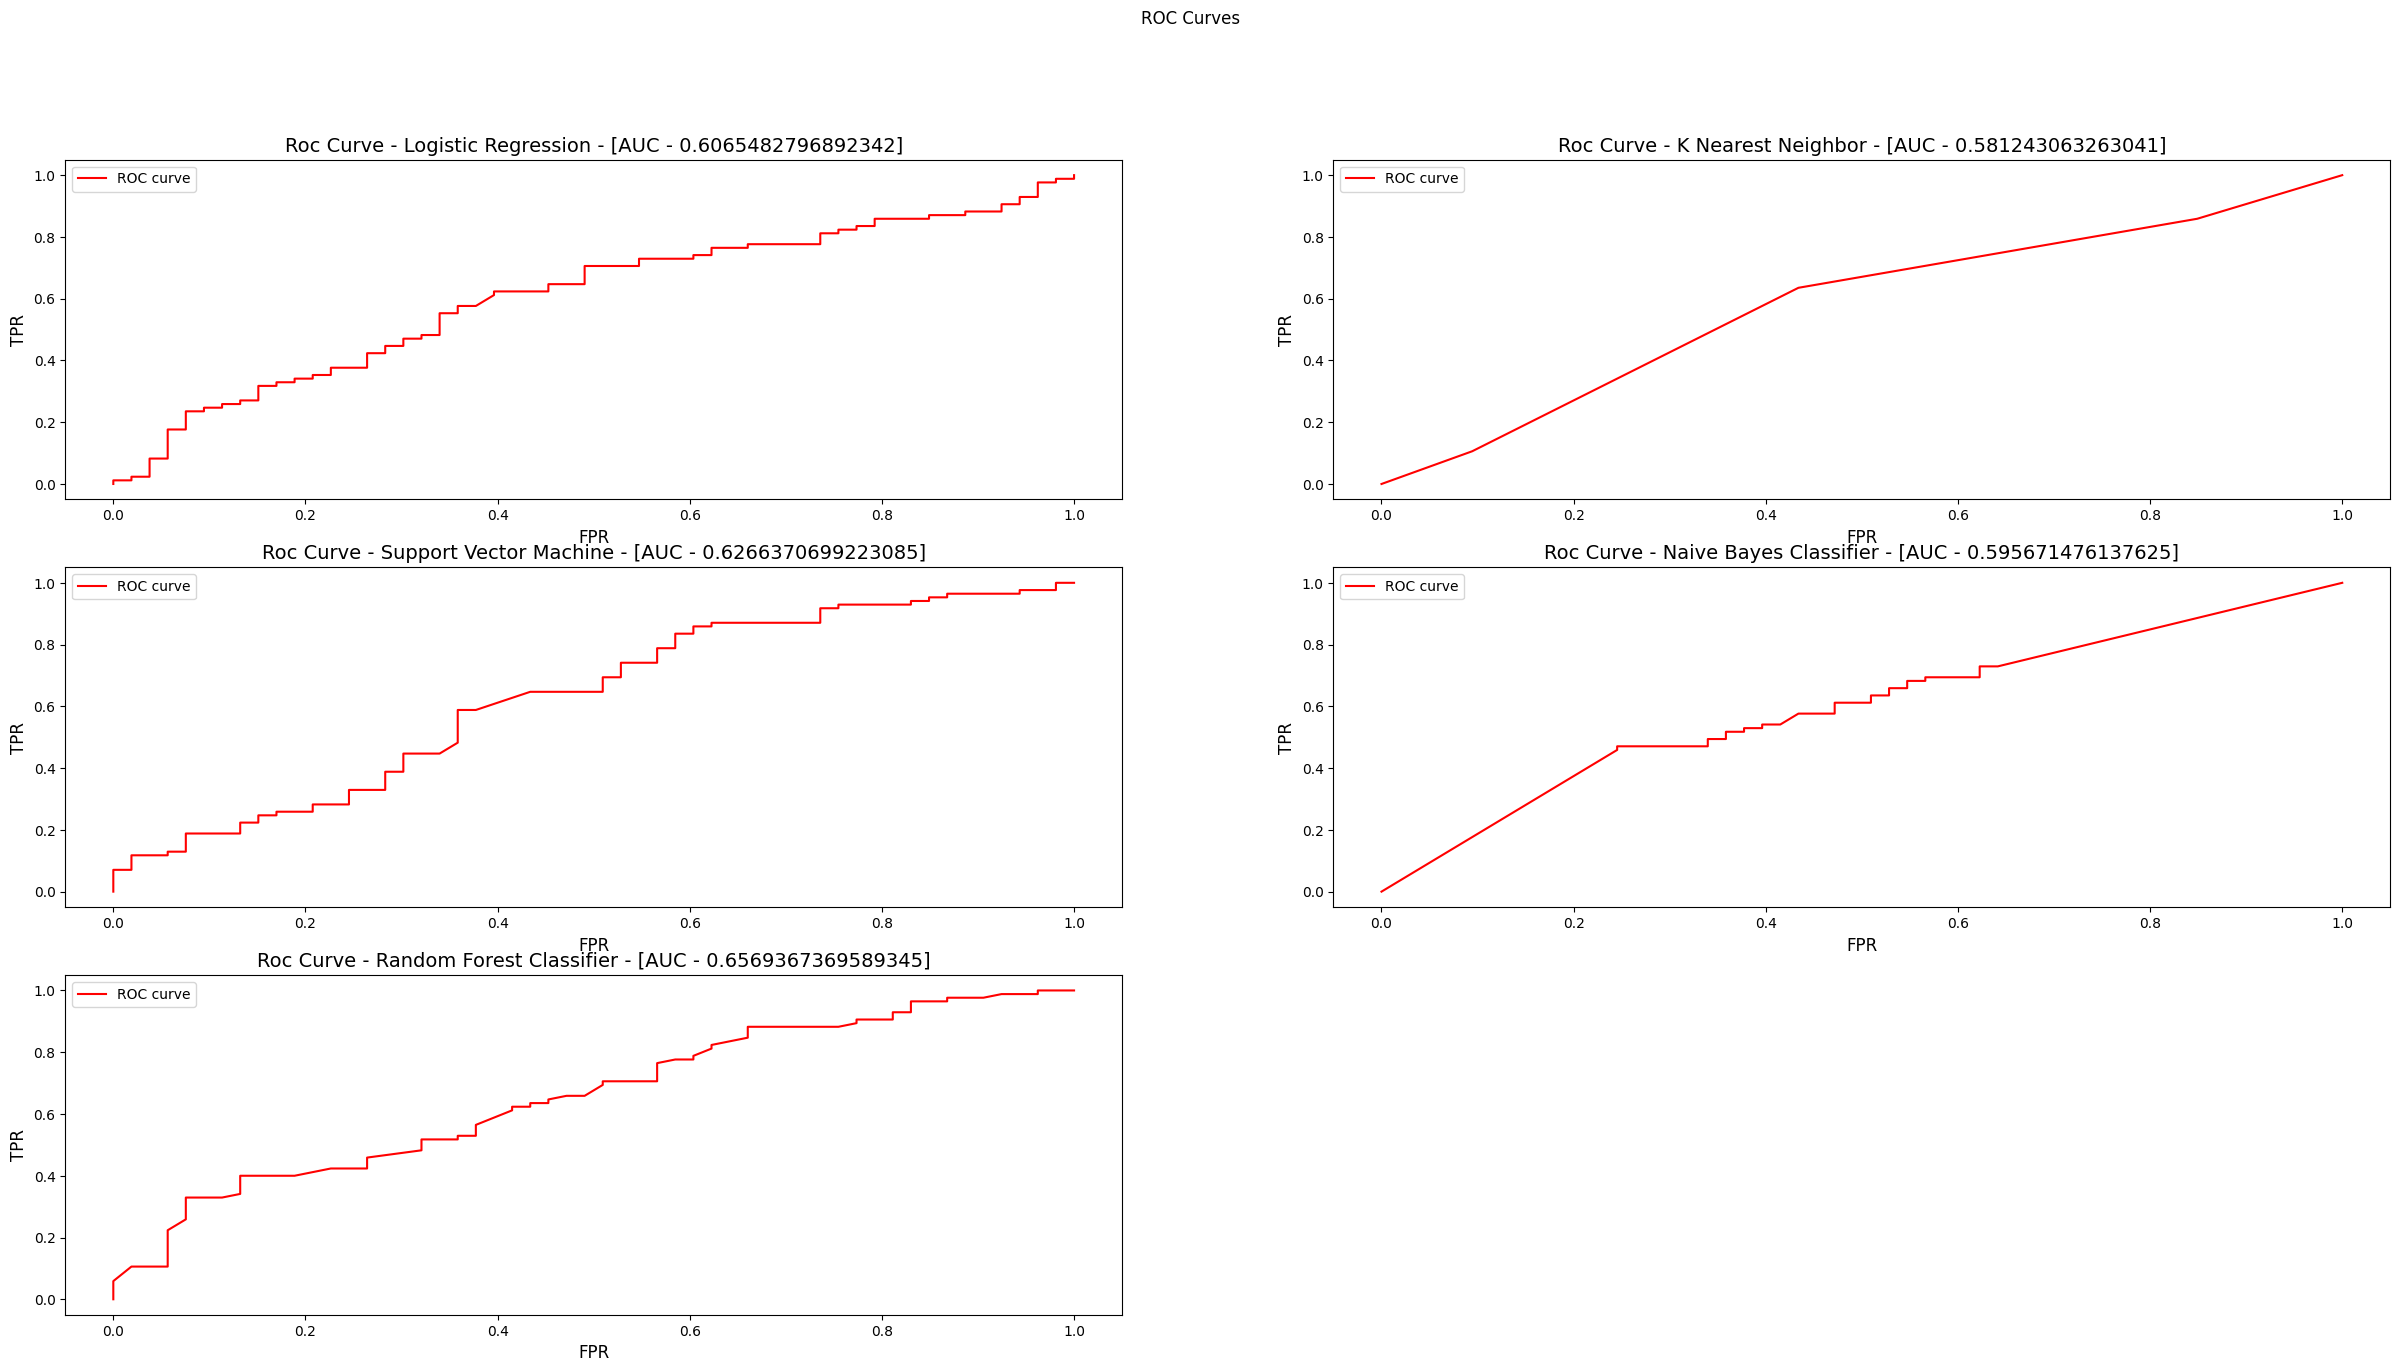

TF*IDF: 

Logistic Regression:
               precision    recall  f1-score   support

       False       0.49      0.64      0.55        53
        True       0.72      0.58      0.64        85

    accuracy                           0.60       138
   macro avg       0.60      0.61      0.60       138
weighted avg       0.63      0.60      0.61       138

K Nearest Neighbor:
               precision    recall  f1-score   support

       False       0.40      0.91      0.55        53
        True       0.72      0.15      0.25        85

    accuracy                           0.44       138
   macro avg       0.56      0.53      0.40       138
weighted avg       0.60      0.44      0.37       138

Support Vector Machine:
               precision    recall  f1-score   support

       False       0.47      0.72      0.57        53
        True       0.74      0.51      0.60        85

    accuracy                           0.59       138
   macro avg       0.61      0.61      0.59       

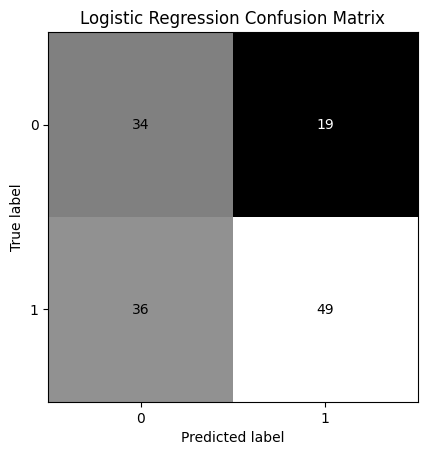

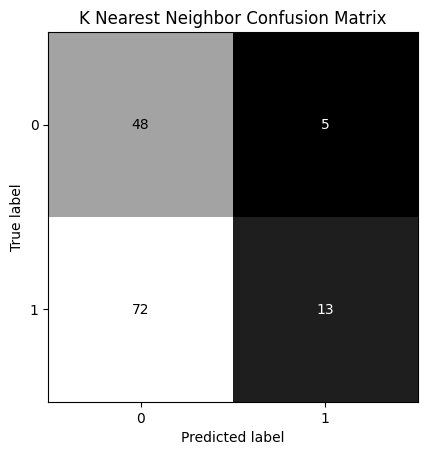

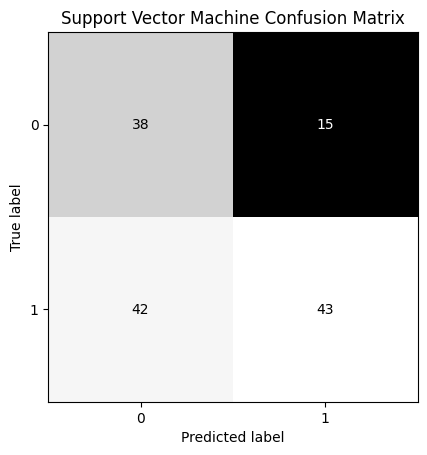

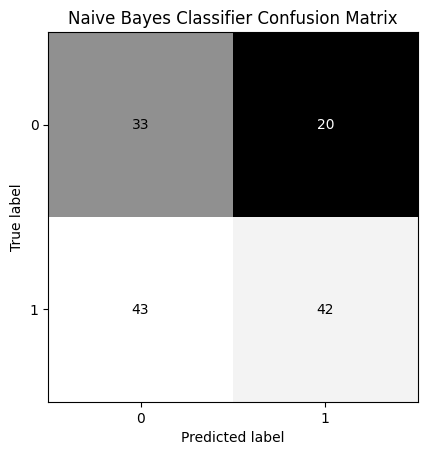

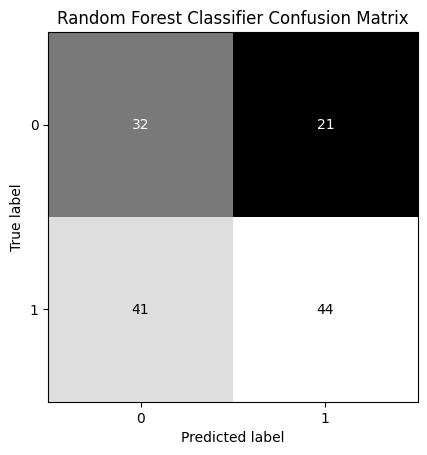

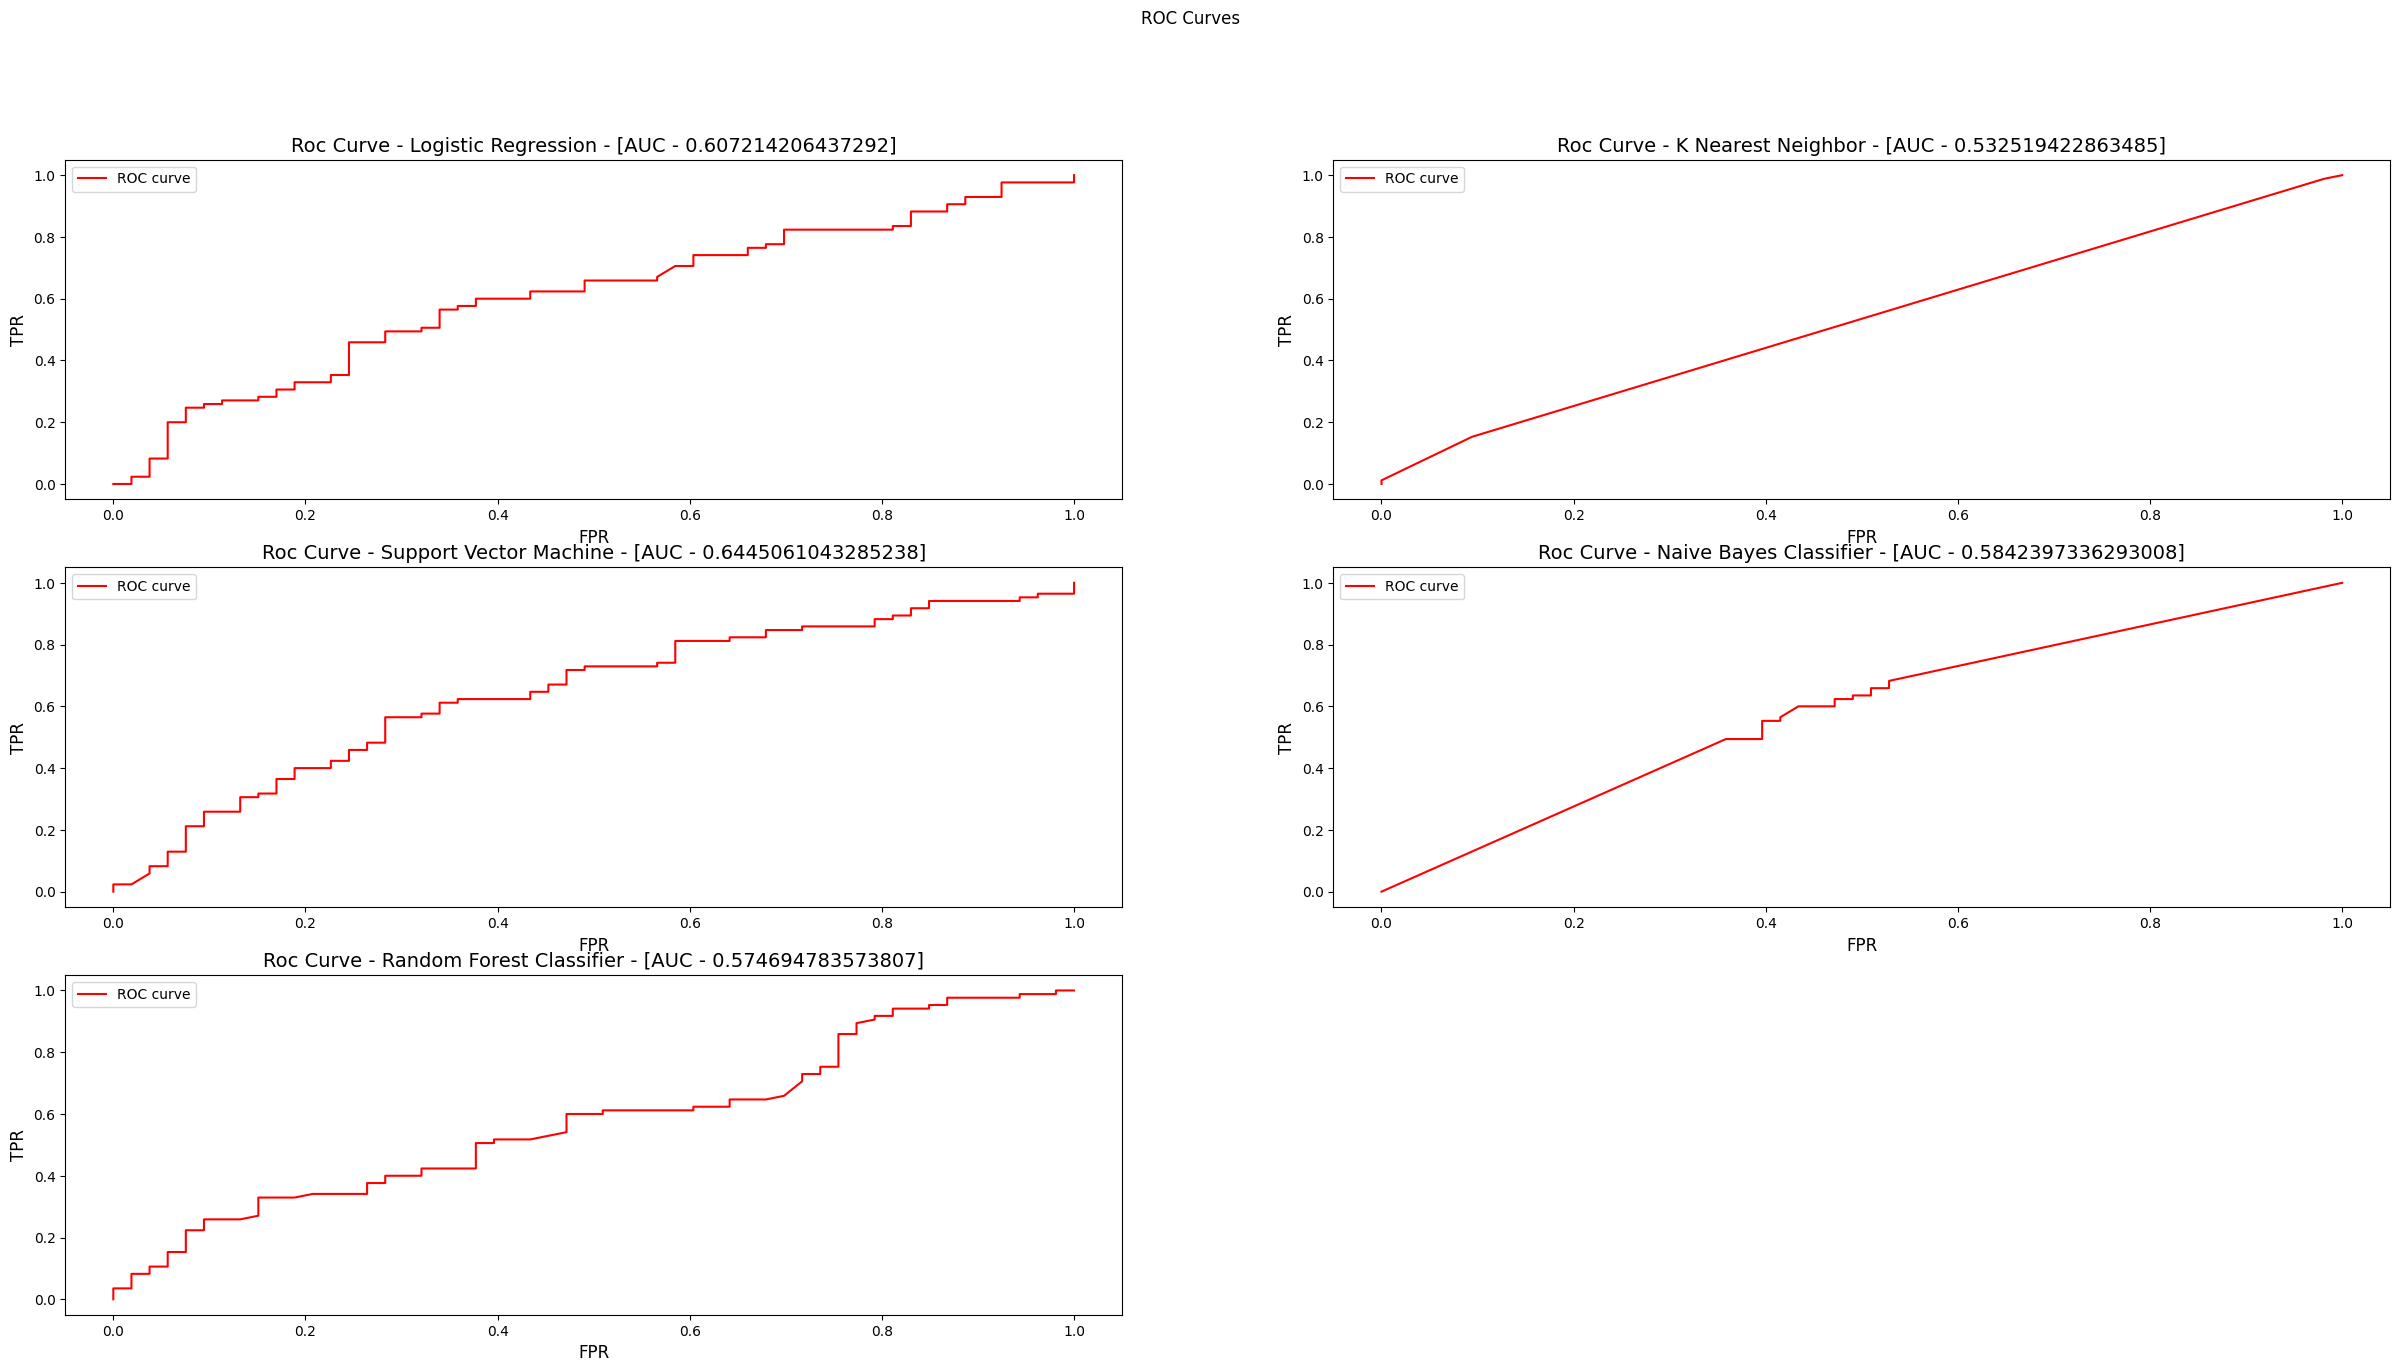

Word2Vec: 

Logistic Regression:
               precision    recall  f1-score   support

       False       0.38      0.42      0.40        53
        True       0.61      0.58      0.59        85

    accuracy                           0.51       138
   macro avg       0.50      0.50      0.50       138
weighted avg       0.52      0.51      0.52       138

K Nearest Neighbor:
               precision    recall  f1-score   support

       False       0.38      0.94      0.54        53
        True       0.40      0.02      0.04        85

    accuracy                           0.38       138
   macro avg       0.39      0.48      0.29       138
weighted avg       0.39      0.38      0.23       138

Support Vector Machine:
               precision    recall  f1-score   support

       False       0.38      0.42      0.40        53
        True       0.61      0.58      0.59        85

    accuracy                           0.51       138
   macro avg       0.50      0.50      0.50     

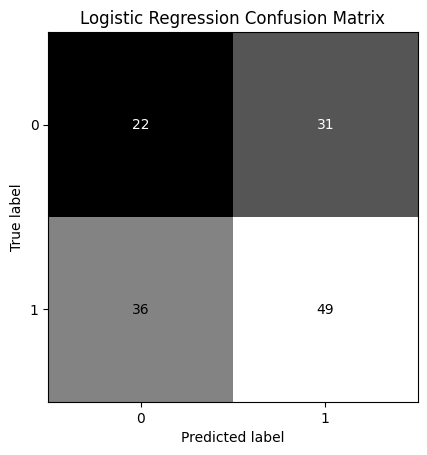

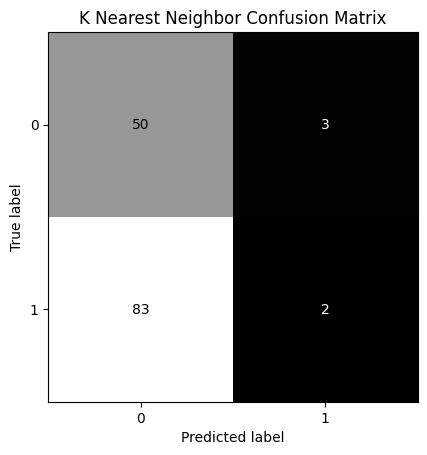

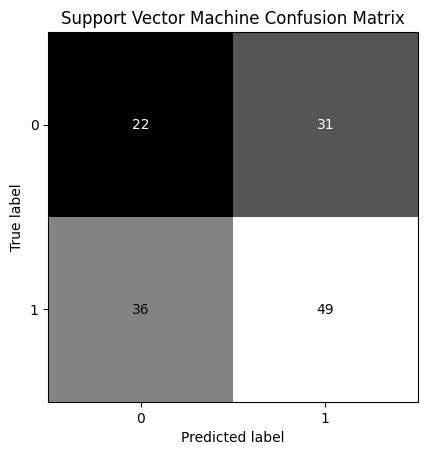

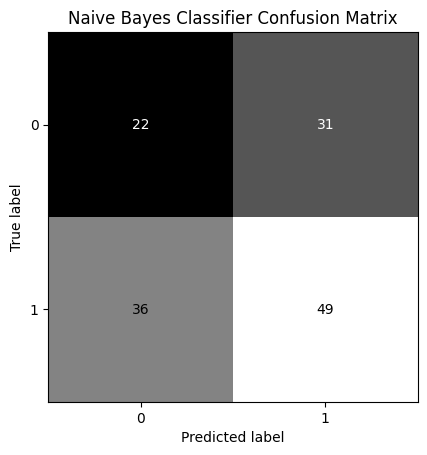

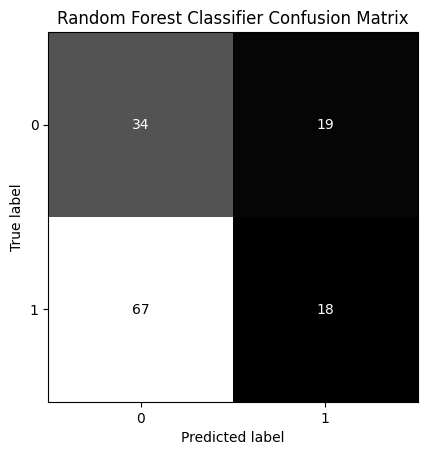

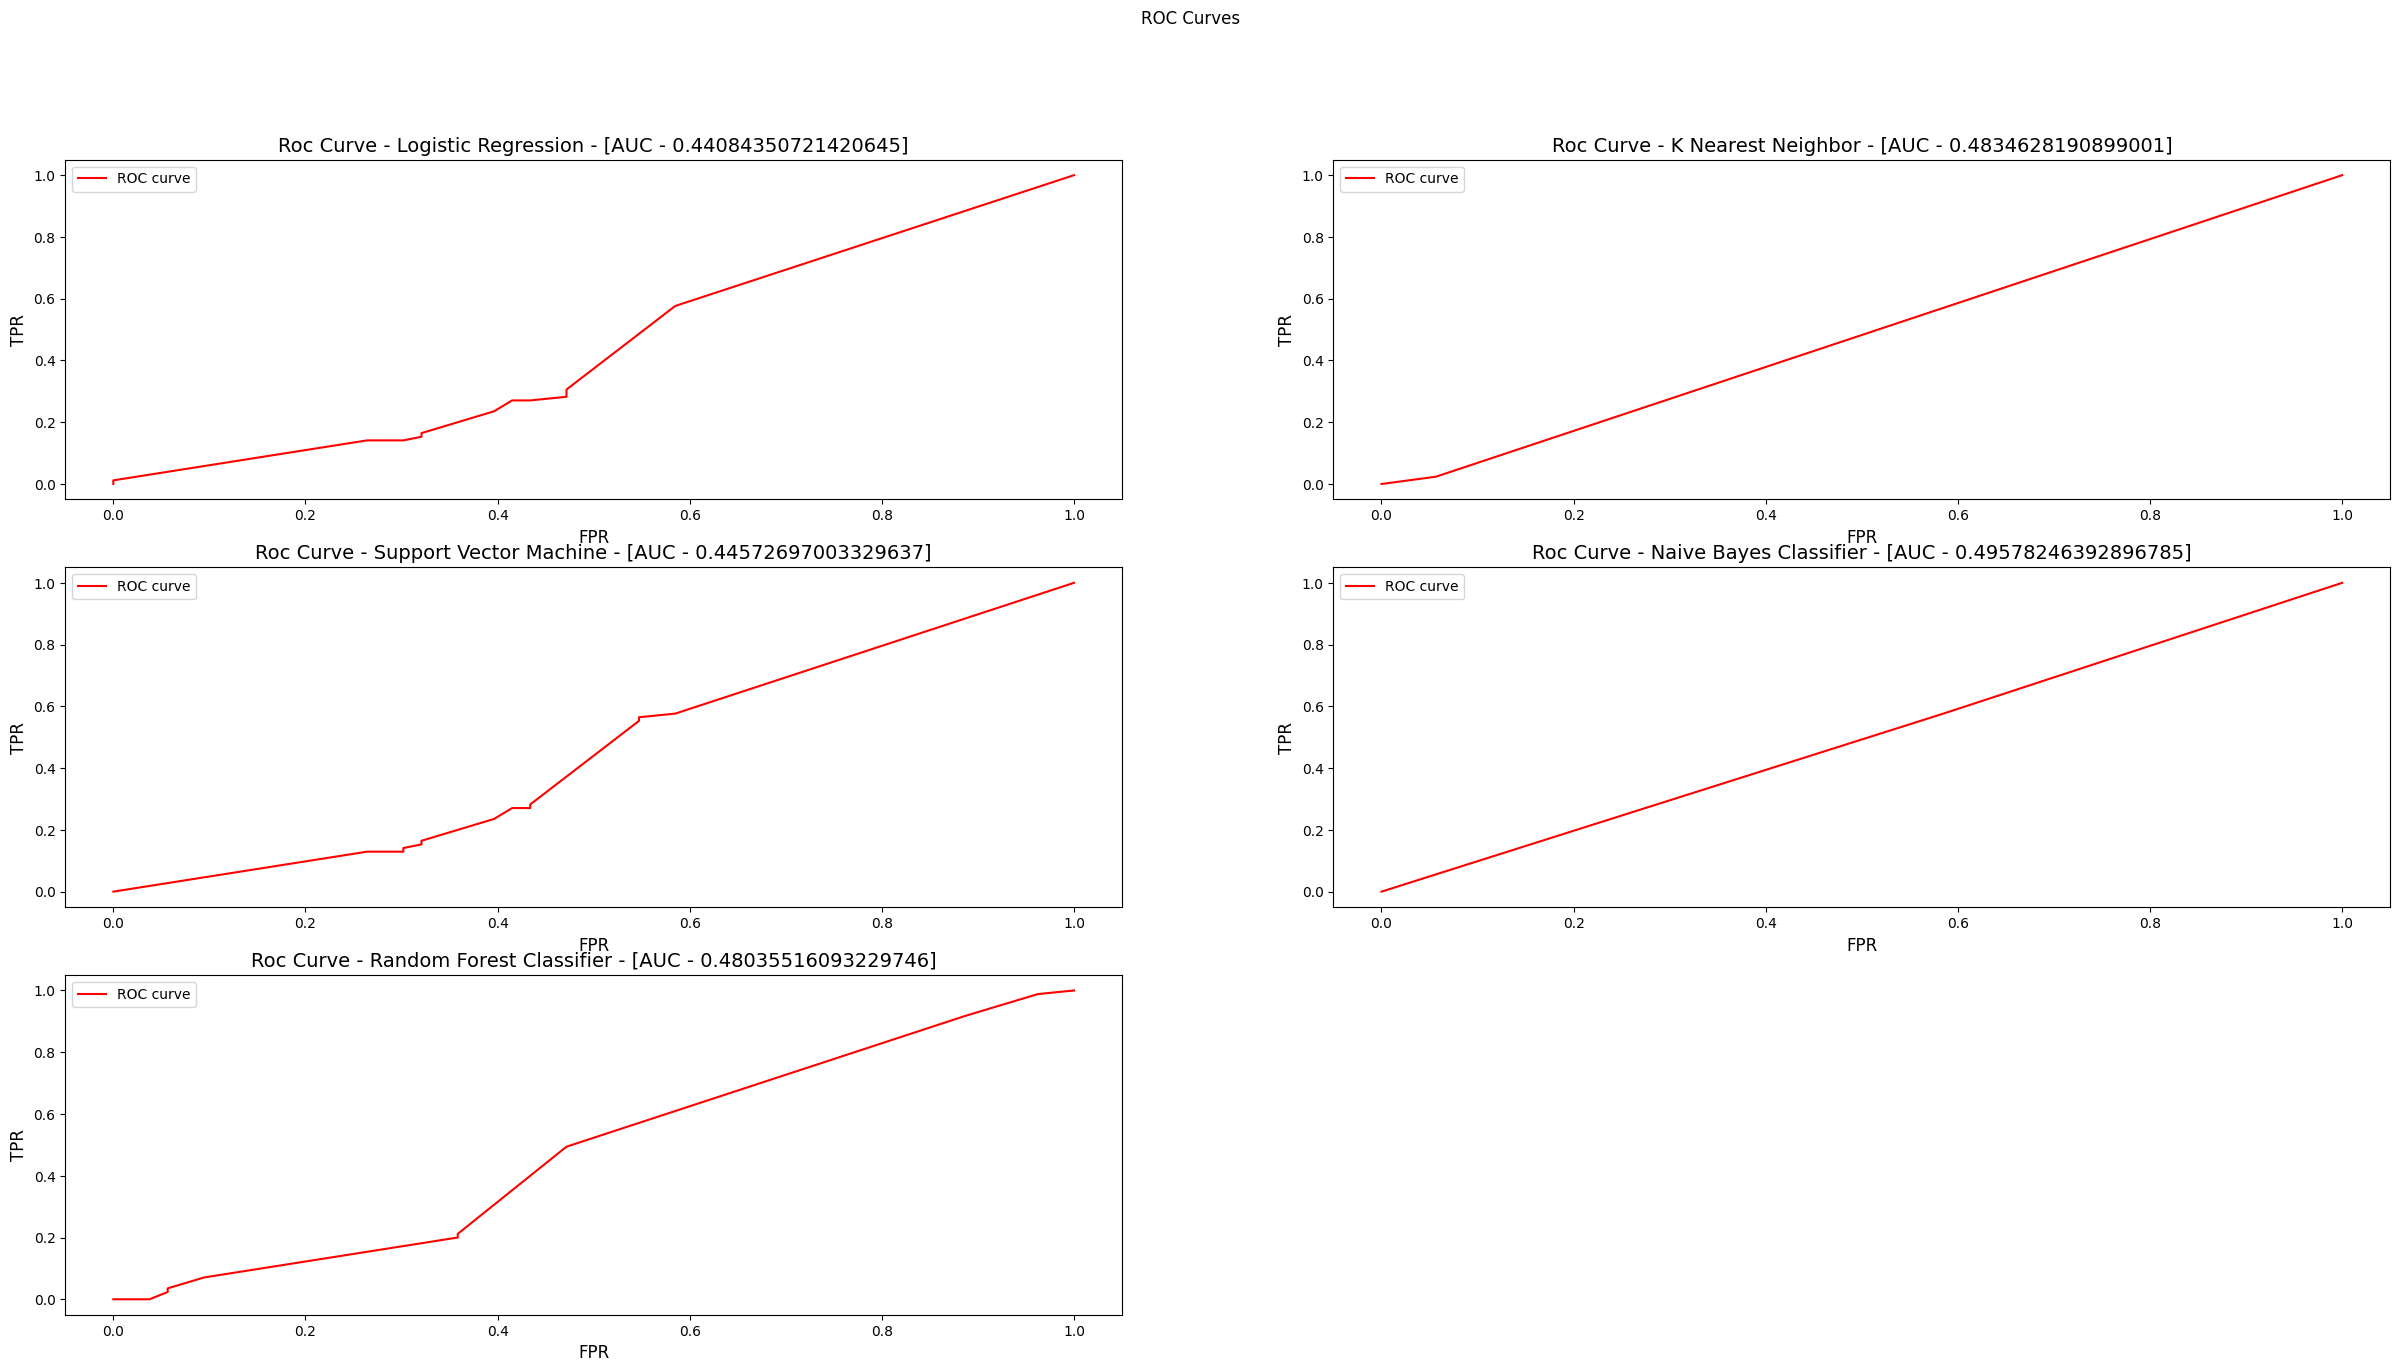

In [18]:
# Bag of Words
print('Bag of Words: \n')
X = bow_vector.toarray()
train_and_predict_models()

# TF*IDF
print('TF*IDF: \n')
X = tfidf_vector.toarray()
train_and_predict_models()

# Word2Vec
print('Word2Vec: \n')
# X = np.array(cbow_vector)
# train_and_predict_models()
X = np.array([vectorize(sentence) for sentence in df['joined tokens']])
train_and_predict_models()


In [19]:
# Combine Audio and NLP Features
X = tfidf_vector.toarray()
print(tfidf_vector)

  (0, 75)	0.4128051532425917
  (0, 360)	0.3423787420337107
  (0, 376)	0.23506868016682608
  (0, 947)	0.3423787420337107
  (0, 72)	0.26737146236570447
  (0, 496)	0.3943633279135899
  (0, 998)	0.2406465342277448
  (0, 890)	0.3683710349736503
  (0, 823)	0.1514150962532815
  (0, 387)	0.21088227797272605
  (0, 354)	0.1582900583294419
  (0, 373)	0.16375804966925853
  (1, 3)	0.24666629903777854
  (1, 806)	0.29098776714717833
  (1, 846)	0.2679047060295692
  (1, 1)	0.2779880612751664
  (1, 86)	0.2779880612751664
  (1, 930)	0.2596660049097905
  (1, 803)	0.29098776714717833
  (1, 540)	0.24134394854441463
  (1, 175)	0.15873499565312982
  (1, 2)	0.1739394193174057
  (1, 805)	0.2596660049097905
  (1, 723)	0.25270028236529335
  (1, 0)	0.2779880612751664
  :	:
  (687, 753)	0.17153347758700094
  (687, 354)	0.1865656494216948
  (687, 373)	0.1930103962751069
  (688, 61)	0.432721989769441
  (688, 674)	0.404201496296718
  (688, 523)	0.404201496296718
  (688, 663)	0.2842891885171971
  (688, 963)	0.276241542